# CONFIG

In [1]:
import json
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

In [6]:
%matplotlib notebook

In [7]:
config_path = '../configs.json'
with open(config_path, 'r') as f:
    config = json.load(f)

In [8]:
config

{'paths': {'clean_voice_path': '~/data/clean',
  'noise_file_path': '~/data/noise',
  'noisy_signal_path': '~/data/noisy_signal',
  'training_data_path': '~/data/training_data',
  'label_path': '~/data/label'},
 'SNR': 10,
 'sampling_rate': 16000,
 'sequence_length': 320,
 'silence_removing_db': 20,
 'n_fft': 510,
 'win_len': 320}

In [9]:
ls {config['paths']['noisy_signal_path']} | head -3

book_00000_chp_0009_reader_06709_0.wav
book_00000_chp_0009_reader_06709_1.wav
book_00000_chp_0009_reader_06709_10.wav
ls: 쓰기 오류


In [10]:
noisy_signal_path = config['paths']['noisy_signal_path']
wav_file = 'book_00000_chp_0009_reader_06709_0.wav'
wav_path = os.path.expanduser(os.path.join(noisy_signal_path, wav_file))

In [11]:
wav_path

'/home/kotech1/data/noisy_signal/book_00000_chp_0009_reader_06709_0.wav'

**Playing wav data**  
https://gist.github.com/tamsanh/a658c1b29b8cba7d782a8b3aed685a24

In [ ]:
from IPython.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

# loading wav file

In [12]:
x, sr = librosa.load(wav_path)

<IPython.core.display.Javascript object>


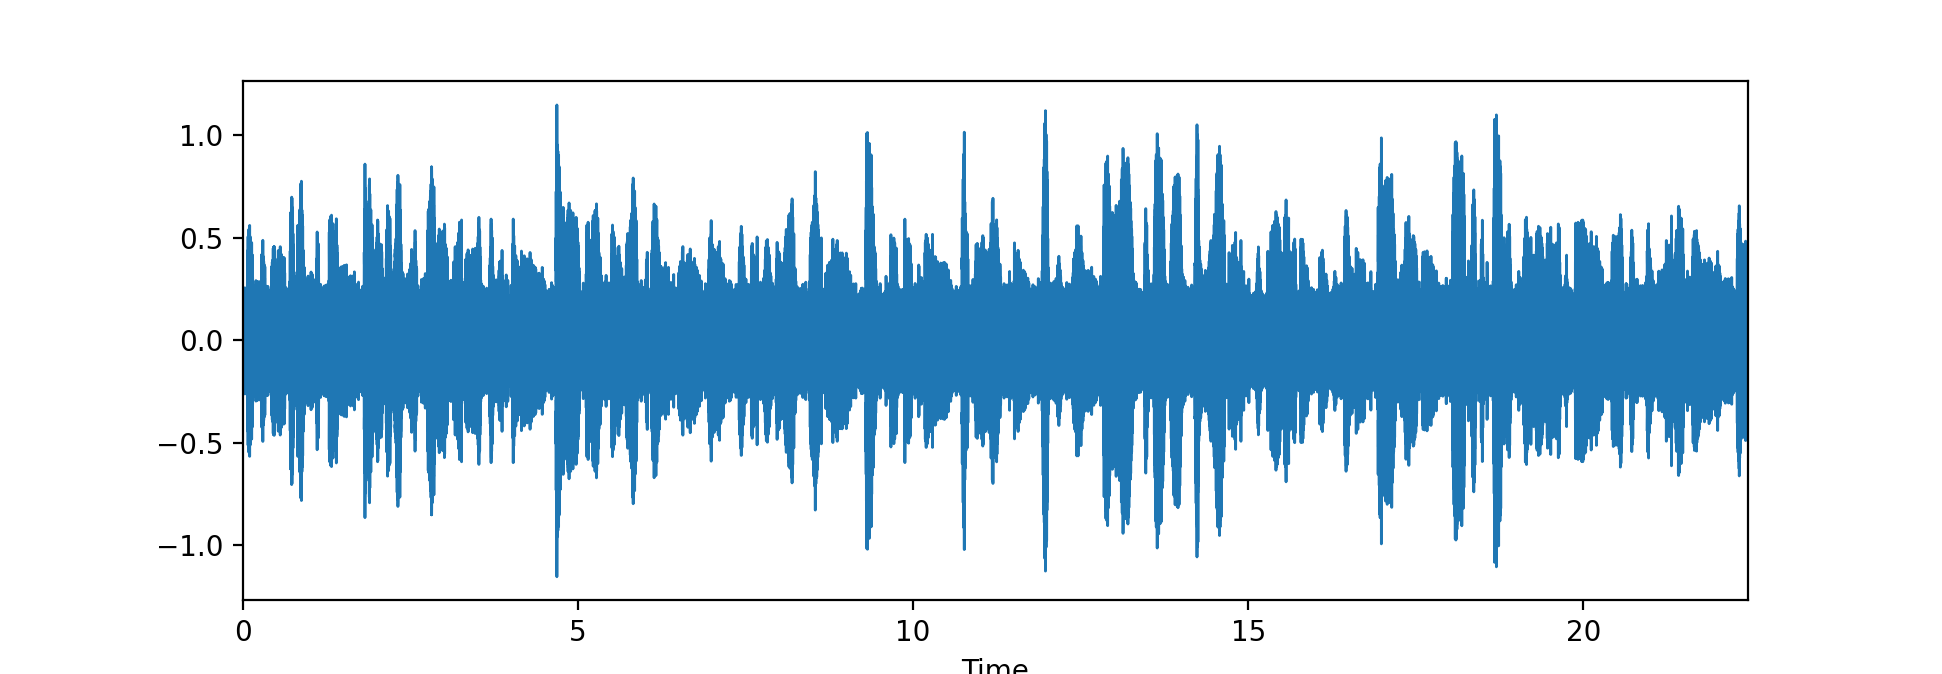

In [15]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

<IPython.core.display.Javascript object>


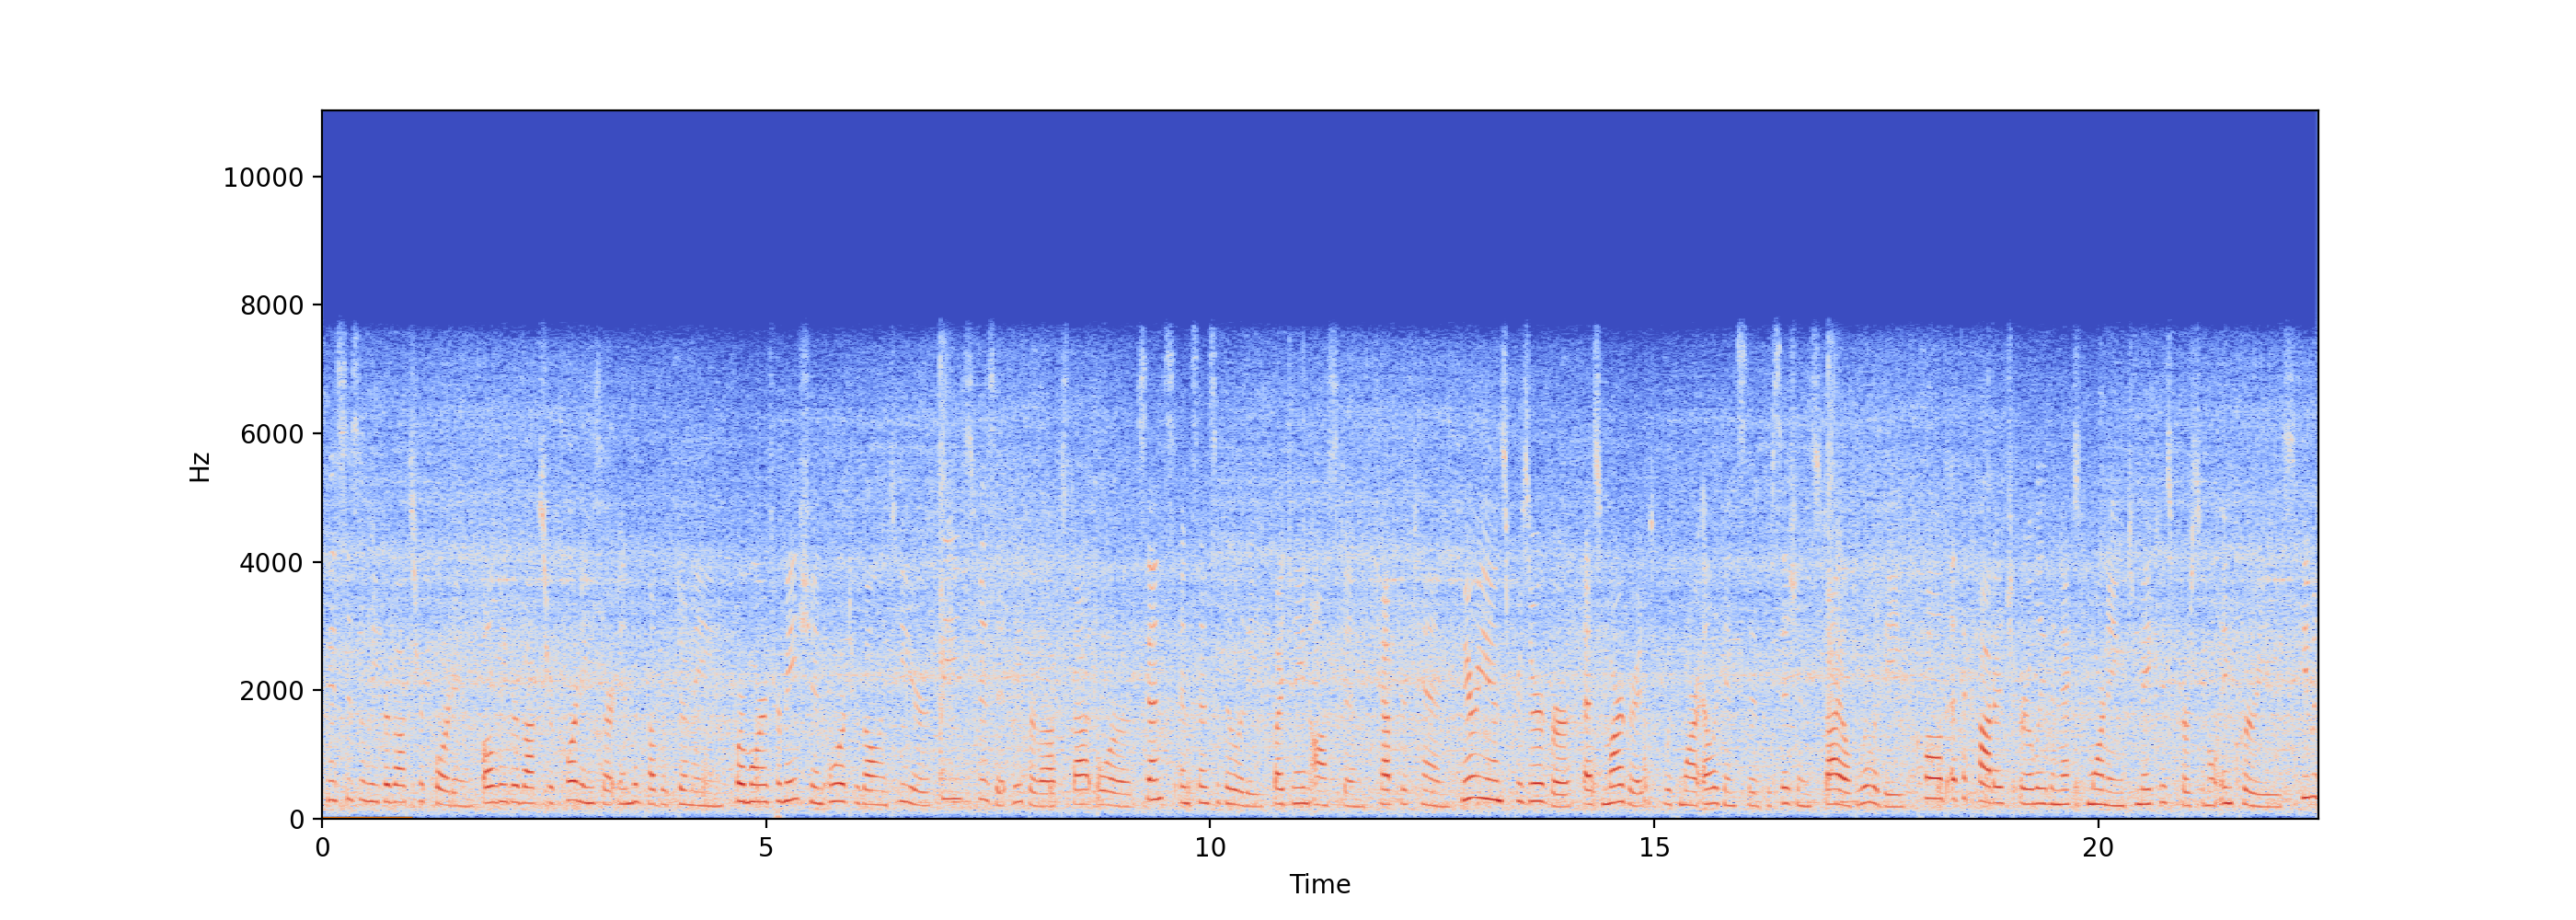

In [16]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [ ]:
Audio(x, rate=sr) 

In [23]:
x.shape, sr

((495155,), 22050)

In [24]:
X.shape

(1025, 968)

The default value, `n_fft=2048` samples, corresponds to a physical duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the default sample rate in librosa. This value is well adapted for music signals. However, in speech processing, the recommended value is 512, corresponding to 23 milliseconds at a sample rate of 22050 Hz. 

In [27]:
# msec
2048*1000/sr

92.87981859410431

In [28]:
#The number of rows in the STFT matrix D is (1 + n_fft/2)
(1 + 2048/2)

1025.0

hop_length: If unspecified, defaults to `win_length // 4`

In [36]:
hop_length = 2048 // 4
hop_length

512

In [35]:
x.shape[0]/hop_length

967.099609375

# Fourier transform

**Definition**:  
$$
g(\omega) = {1\over\sqrt{2\pi}}\int_{-\infty}^\infty f(t)e^{i\omega t} dt
$$

**Definition:** Cosine transform and sine transform

$$
g_c(\omega) = {\sqrt{2\over\pi}}\int_0^\infty f(t)\cos{\omega t} dt\\
g_s(\omega) = {\sqrt{2\over\pi}}\int_0^\infty f(t)\sin{\omega t} dt
$$

**Example 20.2.1**  
$$f(t) = e^{-\alpha|t|}$$  

$$
\begin{align*}
g(\omega) & = \sqrt{1\over 2\pi}\int_{-\infty}^0 e^{\alpha t+i\omega t} dt  +
              \sqrt{1\over 2\pi}\int_0^\infty e^{-\alpha t+i\omega t} dt \\
          & = \sqrt{1\over 2\pi}\left[ {1\over\alpha+i\omega} + {1\over\alpha-i\omega} \right] \\
          & = \sqrt{1\over 2\pi} {2\alpha \over \alpha^2 + \omega^2}
\end{align*}
$$

In [91]:
alpha = 10.0
t = np.linspace(-1, 1, 101)
f_t = np.exp(-alpha*np.abs(t))
w = np.linspace(-1, 1, 101)
g_w = np.sqrt(1/(2*np.pi))*2*alpha/(alpha**2 + w**2)

<IPython.core.display.Javascript object>


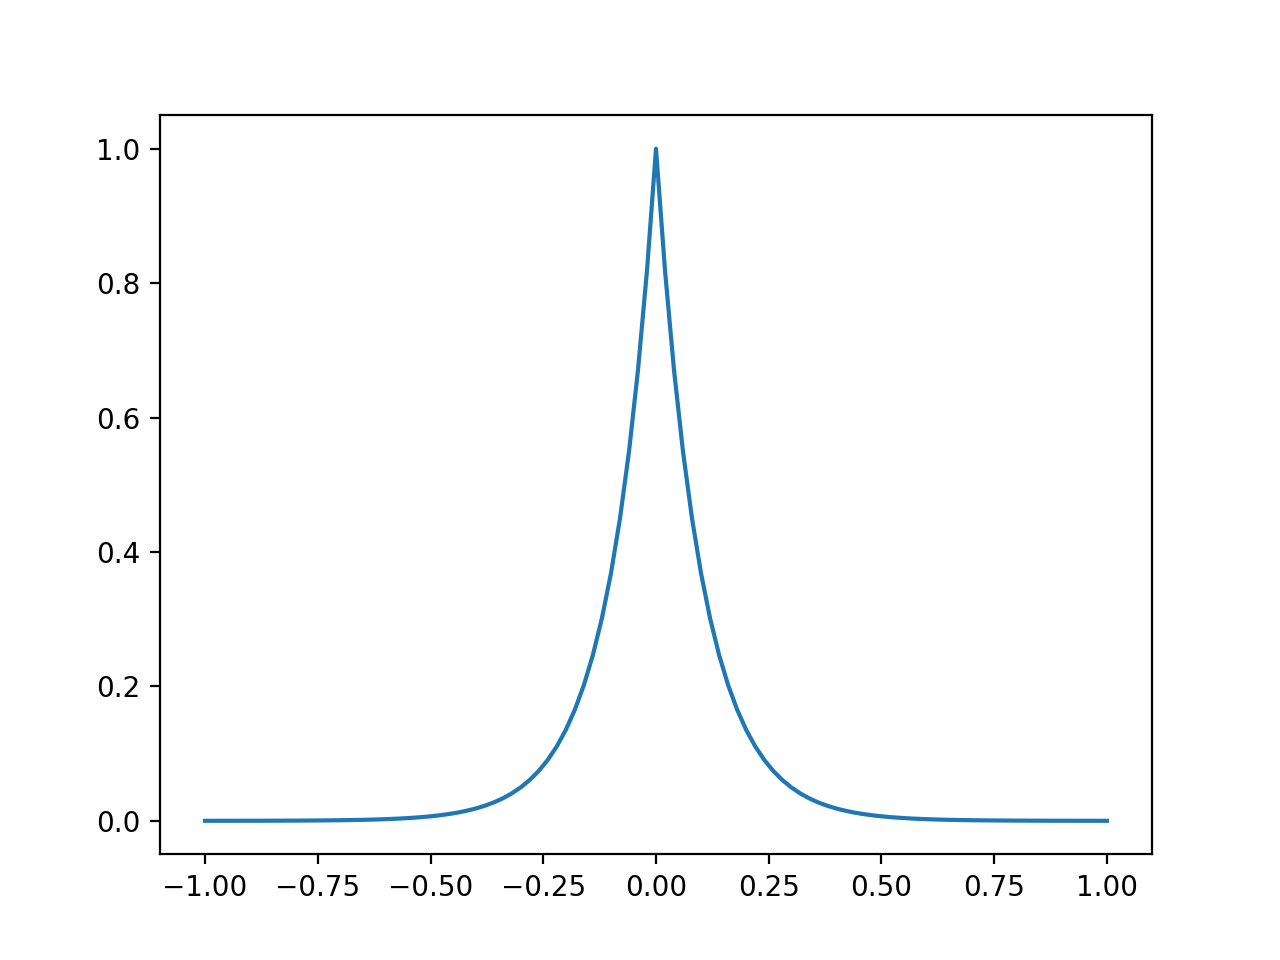

In [94]:
plt.figure()
plt.plot(t, f_t)
plt.show()

<IPython.core.display.Javascript object>


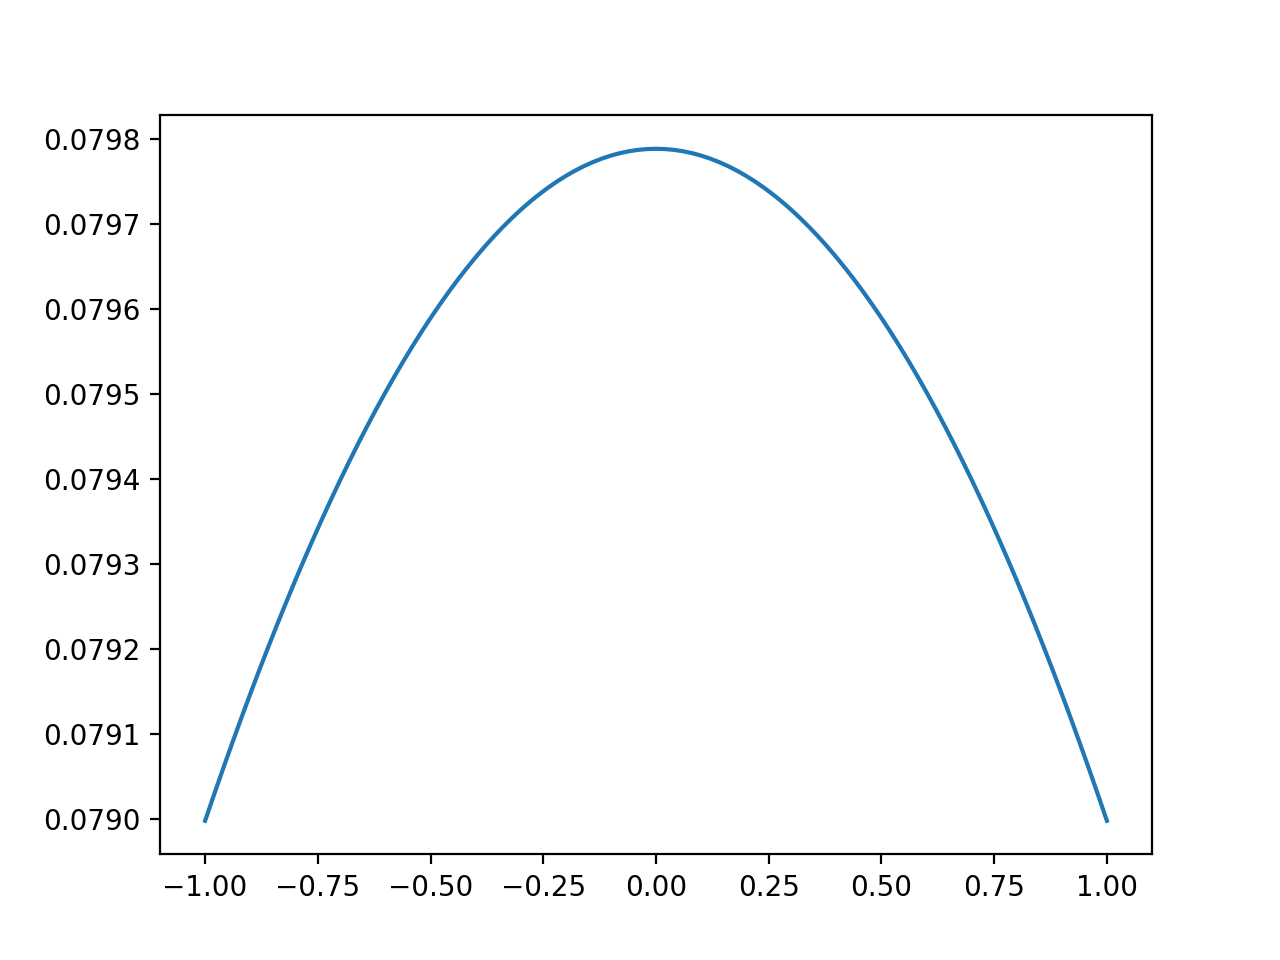

In [95]:
plt.figure()
plt.plot(w, g_w)
plt.show()

**Dirac Delta function**
$$
\delta(x) = 0, \text{       } x\ne 0\\
\int_{-a}^{b}f(x)\delta(x) dx = f(0), \text{    for  } a,b > 0
$$

**Property**  
$$
\int_{-\infty}^\infty \delta(x) dx = 1\\
\int_{-\infty}^\infty f(x)\delta(x-a) dx = f(a)
$$

(1) square function
$$
\delta_n(x) = \left\{\begin{align*}
n && \text{for } |x| \le {1\over2n} \\ 
0 && \text{for } |x| \gt {1\over2n}
\end{align*}\right.
$$
(2) Gaussian function
$$
\delta_n(x) = N(1/n, 0)
$$
(3) Sinc function
$$
\delta_n(x) = {n\over\pi}\text{sinc}(nx) = {\sin(nx)\over\pi x} = {1\over2\pi}\int_{-n}^n e^{-ixt} dt
$$  

**Examples**  
  
$f(t) = \delta(t)$
$$
g(\omega) = \sqrt{1\over2\pi} \int_{-\infty}^\infty\delta(t)e^{i\omega t} dt = \sqrt{1\over 2\pi}
$$

## Residue theorem

Residue at $z = z_0$:  
$$
a_{-1, z_0} = \left . (z-z_0)f(z) \right|_{z=z_0}
$$

$$
f(z) = {1\over(z-z_0)(z-z_1)} \\
a_{-1,z_0} = {1\over(z_0-z_1)} \\
a_{-1,z_1} = {1\over(z_1-z_0)}
$$

**Residue Theorem**  
$$
\oint f(z)dz = 2\pi i(a_{-1,z_0}+a_{-1,z_1}+...) = 2\pi i(\text{sum of the enclosed residues})
$$


**example**  

$$
\int_{-\infty}^\infty {\sin x\over x} dx = 2\int_0^\infty {\sin x\over x} dx \equiv 2I
$$

$$\begin{align*}
I &= \int_0^\infty {\sin x\over x} dx = \int_0^\infty {e^{ix}-e^{-ix}\over 2ix} dx = \int_0^\infty {e^{ix}\over 2ix} dx - \int_{0}^{\infty} {e^{-ix}\over 2ix} dx\\
&= \int_0^\infty {e^{ix}\over 2ix} dx - \int_0^{-\infty} {e^{ix}\over 2ix}dx=\int_{-\infty}^\infty {e^{ix}\over 2ix} dx
\end{align*}$$

Residue of ${e^{iz}/ 2iz}$: $\pi$

![](https://i.imgur.com/dtSqeOV.jpg)

$$
\oint {e^{iz}\over 2iz} dz = I+\int_{c_r}{e^{iz}\over 2iz} dz+\int_{c_R}{e^{iz}\over 2iz}=0
$$  

$$
I - {\pi\over2} + 0 = 0\to I = {\pi\over2}
$$

$$
\int_{-\infty}^\infty {\sin x \over x} dx = \pi
$$

In [97]:
t = np.linspace(-1, 1, 101)
f_t = t*0.
#f_t[50] = np.inf
f_t[50] = 0.9999

w = np.linspace(-1, 1, 101)
g_w = np.sqrt(1/(2*np.pi))*(w*0+1.)

<IPython.core.display.Javascript object>


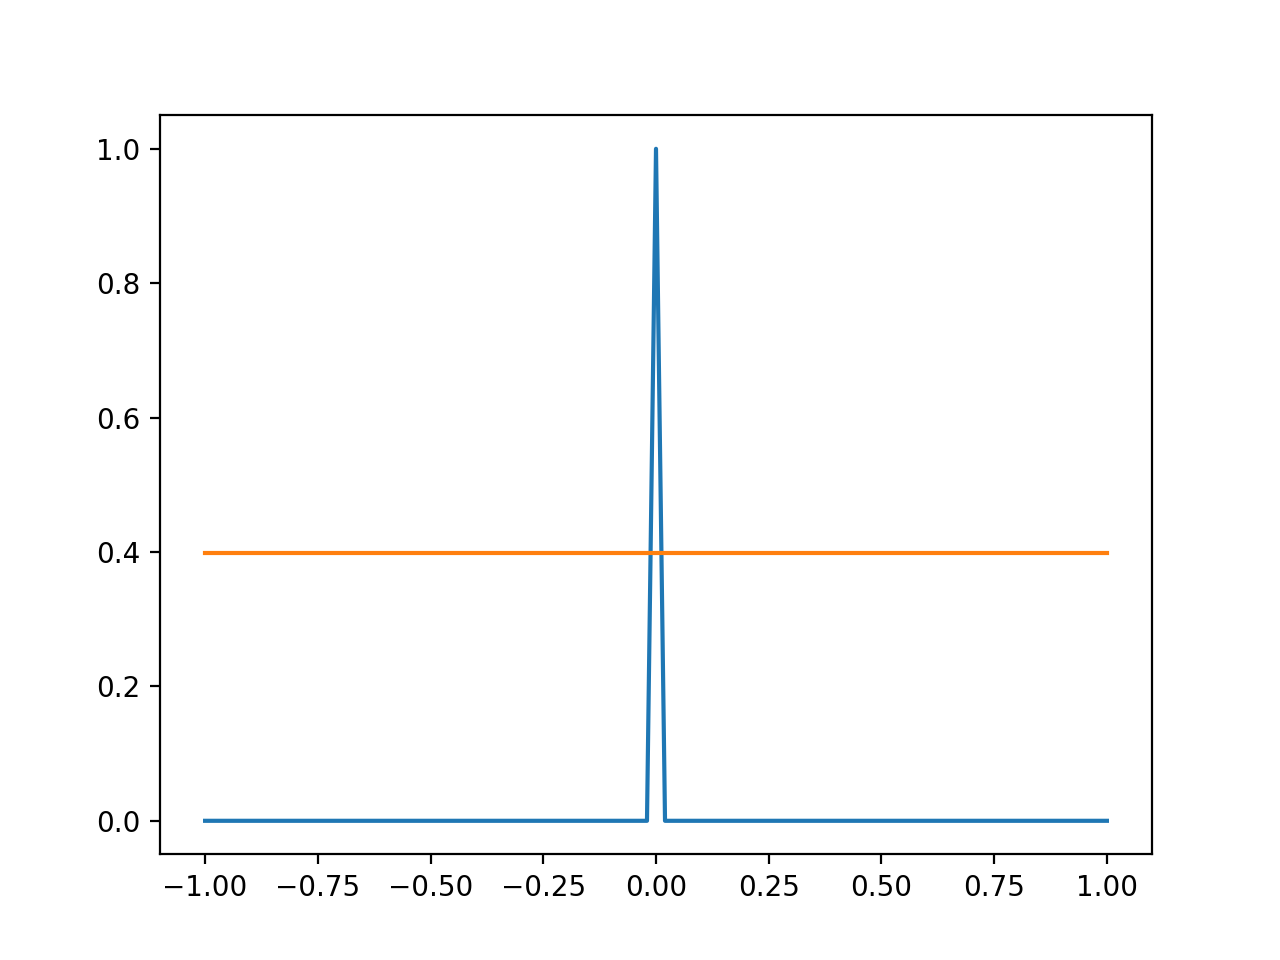

In [98]:
plt.figure()
plt.plot(t, f_t)
plt.plot(w, g_w)
plt.show()

Residue at $z = z_0$:  
$$
a_{-1} = \left . (z-z_0)f(z) \right|_{z=z_0}
$$

$$
f(z) = {1\over(z-z_0)(z-z_1)} \\
a_{-1,z_0} = {1\over(z_0-z_1)} \\
a_{-1,z_1} = {1\over(z_1-z_0)}
$$

**Residue Theorem**  
$$
\oint f(z)dz = 2\pi i(a_{-1,z_0}+a_{-1,z_1}+...) = 2\pi i(\text{sum of the enclosed residues})
$$


$f(t) = 2\alpha\sqrt{1/2\pi}/(\alpha^2 + t^2)$:  
$$
g(\omega) = {1\over2\pi}\int_{-\infty}^\infty{2\alpha e^{i\omega t}\over (t-i\alpha)(t+i\alpha)}dt
$$

$$
g(\omega) = {1\over2\pi} (2\pi i) {e^{-\alpha w}\over i}\\
g(\omega) = {1\over2\pi} (2\pi i) {e^{-\alpha w}\over i} \text{  for   } \omega > 0\\
g(\omega) = {1\over2\pi} (-2\pi i) {e^{+\alpha w}\over -i} \text{  for   } \omega < 0
$$  
$$
g(\omega) = e^{-\alpha |w|}
$$

**Example 20.2.2**  
Gaussian $f(t) = e^{-at^2}$  

$$
g(\omega) = {1\over\sqrt{2\pi}}\int_{-\infty}^\infty e^{-at^2}e^{i\omega t} dt
$$

$$
-at^2 + i\omega t = -a\left(t-{i\omega\over2a}\right)^2 - {\omega^2\over4a}
$$

$$
g(\omega) = {1\over\sqrt{2\pi}} e^{-\omega^2/4a} \int_{-T-i\omega/2a}^{T-i\omega/2a} e^{-as^2}ds\\
$$
Normal distribution:  
$$
{1\over\sqrt{2\pi}\sigma}\exp\left[-{1\over2}\left({x-\mu\over\sigma}\right)^2\right]
$$

$$
g(\omega) = {1\over\sqrt{2\pi}}e^{-\omega^2/4a}\sqrt{\pi\over a} = {1\over\sqrt{2a}}\exp\left[-{\omega^2\over4a}\right]
$$

**Finite wave train**  
$$
f(t) = 
\left\{\begin{align*}
\sin\omega_0t, && |t| < {N\pi\over\omega_0} \\ 
0, && |t| > {N\pi\over\omega_0}
\end{align*}\right.
$$

In [175]:
w_0 = 1
N = 5
range_t = 1.5
t = np.linspace(-range_t*N*np.pi/w_0, range_t*N*np.pi/w_0, 201)
f_t = np.sin(w_0*t)
f_t[np.where((t > N*np.pi/w_0) | (t < -N*np.pi/w_0))] = 0.

<IPython.core.display.Javascript object>


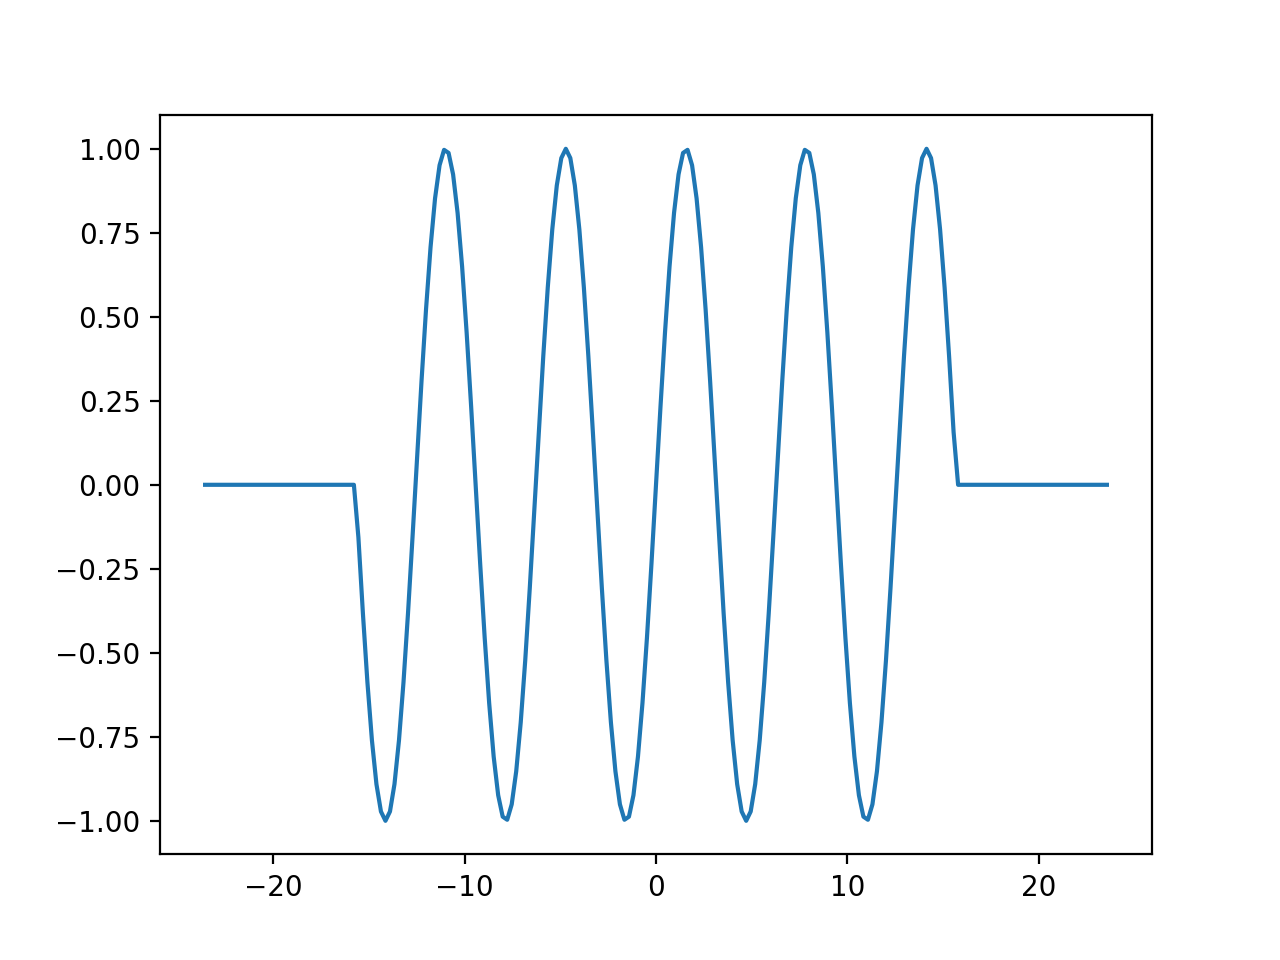

In [176]:
plt.figure()
plt.plot(t, f_t)
plt.show()

$$
g_s(\omega) = \sqrt{2\over\pi}\int_0^{N\pi/\omega_0}\sin\omega_0t\sin\omega t\ dt
$$

$$
2\sin(a)\sin(b) = \cos(a-b) - \cos(a+b)
$$

$$
e^{ia} =  \cos a + i\sin a \\
e^{ib} =  \cos b + i\sin b \\
e^{i(a+b)} =  \cos(a+b) + i\sin(a+b) \\
e^{ia}e^{ib} = \cos a\cos b - \sin a\sin b + i(\cos a\sin b + \sin a\sin b)
$$

$$
g_s(\omega) = \sqrt{2\over\pi}\left[{\sin[(\omega_0-\omega)(N\pi/\omega_0]\over2(\omega_0-\omega)}
- {\sin[(\omega_0+\omega)(N\pi/\omega_0]\over2(\omega_0+\omega)}\right]
$$

In [177]:
range_w = 2.
w = np.linspace(-range_w, range_w, 201)

def sinc(x):
    val = x[:]
    val[x != 0] = np.sin(x[x != 0])/x[x!= 0]
    val[x == 0] = 1.
    return val
    
#g_w = np.sqrt(2/np.pi)*(np.sin((w_0-w)*(N*np.pi/w_0))/(2*(w_0-w)) - np.sin((w_0+w)*(N*np.pi/w_0))/(2*(w_0+w)))
g_w_n = np.sqrt(2/np.pi)*(sinc((w_0-w)*(N*np.pi/w_0))*(N*np.pi/w_0)/2 - sinc((w_0+w)*(N*np.pi/w_0))*(N*np.pi/w_0)/2)

<IPython.core.display.Javascript object>


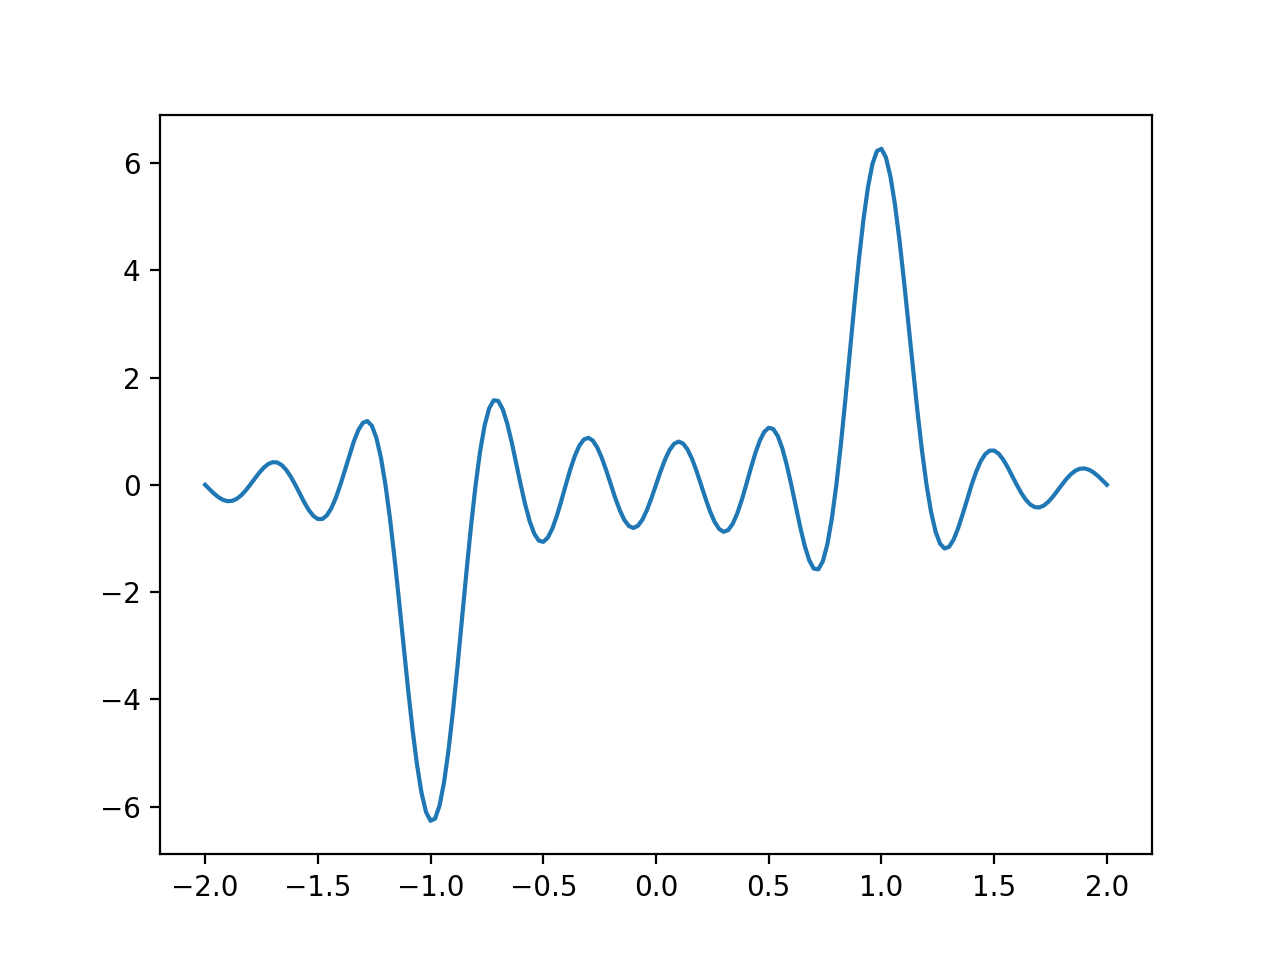

In [178]:
plt.figure()
plt.plot(w, g_w_n)
plt.show()

**Inverse Fourier Transform**

$$
\delta(t) = {1\over2\pi} \int_{-\infty}^\infty e^{i\omega t} d\omega\\
$$

$$
\begin{align*}
f(x) &= \int_{-\infty}^\infty f(t)\delta(t-x) dt\\
&= {1\over2\pi}\int_{t=-\infty}^{t=\infty} f(t) \int_{-\infty}^\infty e^{i\omega(t-x)} d\omega\ dt\\
& = {1\over2\pi}\int_{-\infty}^\infty e^{-i\omega x}\int_{t=-\infty}^{t=\infty}f(t)e^{i\omega t} dt\ d\omega \\
& = {1\over\sqrt{2\pi}}\int_{-\infty}^\infty g(\omega) e^{-i\omega x} d\omega \\
\end{align*}\\
$$

# Discrete Fourier Transform

$$
x_k = {2\pi k\over N}, \ \ k = 0,...,N-1 \\
\varphi_p(x) = e^{ipx}\\
\begin{align*}
\langle\varphi_p|\varphi_q\rangle &\equiv \sum_{k=0}^{N-1} \varphi_p^*(x_k)\varphi_q(x_k)\\
&= \sum_{k=0}^{N-1} e^{2\pi ik(q-p)/N} = \sum_{k=0}^{N-1} r^k
\end{align*}\\
r = e^{2\pi i (q-p)/N}\\
r^k = {1-r^N\over1-r}\\
r^N = e^{2\pi i(q-p)} = 1\\
\langle\varphi_p|\varphi_q\rangle = N\sum_{n=-\infty}^\infty \delta_{q-p, nN}\\
\varphi_{p+N}(x_k) = e^{2\pi i(p+N)k/N} = e^{2\pi i pk/N} = \varphi_p(x_k)\\
p,q = 0,..,N-1\\
\langle\varphi_p|\varphi_q\rangle = N\delta_{pq}\\
$$

$$
g_p = N^{-1/2}\sum_{k=0}^{N-1} e^{2\pi ikp/N}f_k\\
f_j = N^{-1/2}\sum_{p=0}^{N-1} e^{-2\pi i jp/N}g_p\\
f_j = N^{-1}\sum_{p=0}^{N-1}\sum_{k=0}^{N-1}e^{2\pi i(k-j)p/N}f_k = \sum_{k-0}^{N-1}\delta_{kj}f_k = f_j
$$

## real-input DFT

http://www.fftw.org/fftw3_doc/The-1d-Real_002ddata-DFT.html  

https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft  

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html  

# STFT test

hann window:

https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2_STFT-Window.html


In [225]:
window_size = 2048
t = np.arange(0, window_size)

In [308]:
N = 10.3
w_0 = N*2*np.pi/window_size
x = np.sin(w_0*t)

<IPython.core.display.Javascript object>


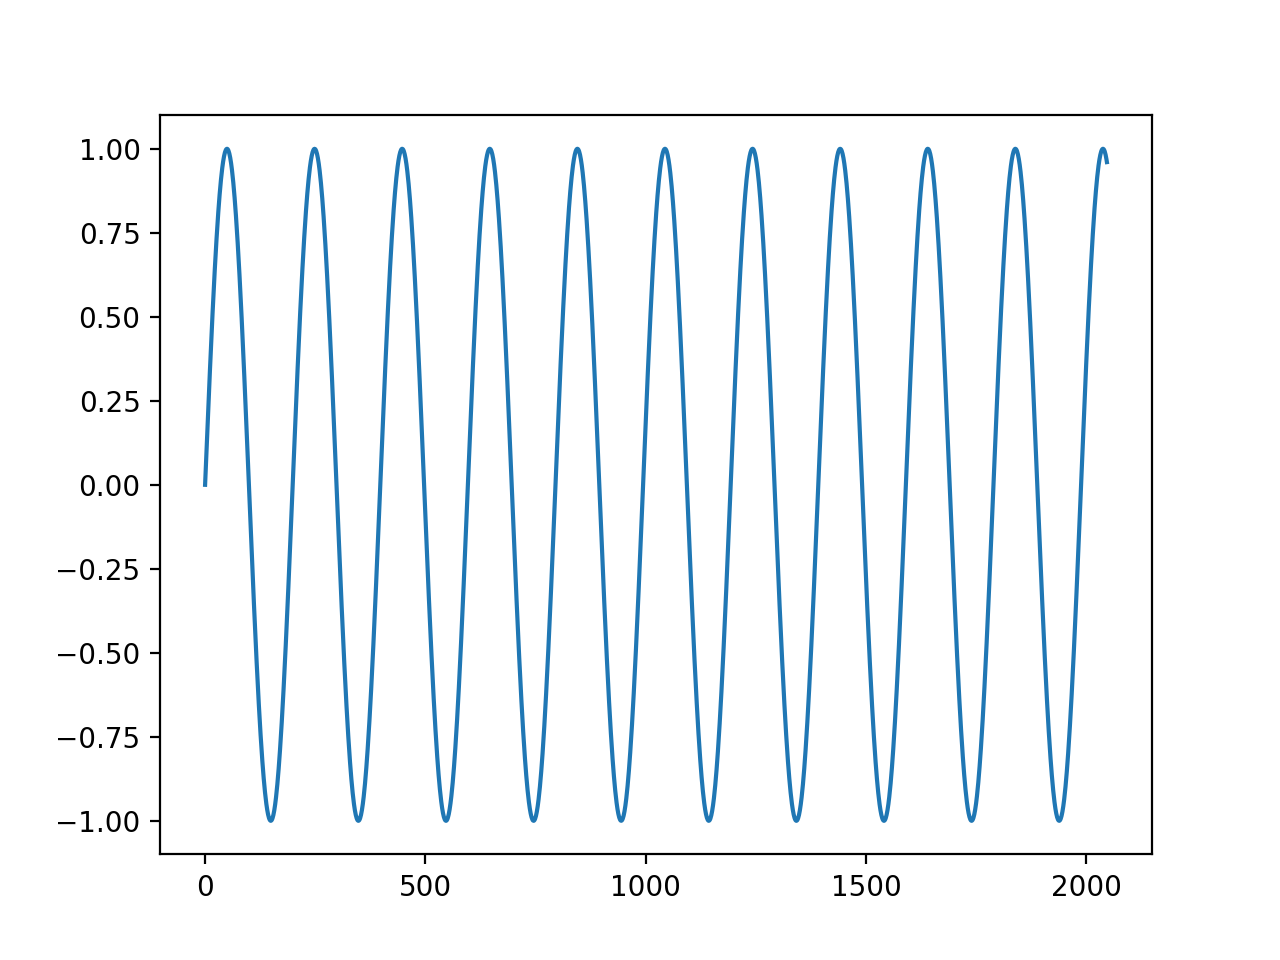

In [309]:
plt.figure()
plt.plot(t, x)
plt.show()

In [402]:
def mywindow(N):
    print('window size =', N)
    return scipy.signal.get_window('hann', N, fftbins=True)

In [403]:
window = np.empty((window_size,))
window[:] = 1.0
window = 'hann'
#window = np.hanning(window_size)
window = mywindow
#window = scipy.signal.windows.hann
#window = 'hann'
X = librosa.stft(x, window=window, hop_length=window_size, center=False)
y_hat = librosa.istft(X, window=window, hop_length=window_size, center=False)
#X = librosa.stft(x)
#y_hat = librosa.istft(X[:, 0:5])
X_abs = abs(X)
X.shape, y_hat.shape

window size = 2048
window size = 2048
window size = 2048


((1025, 1), (2048,))

In [410]:
import scipy

window_data = scipy.signal.get_window('hann', window_size, fftbins=True)
window_data.shape


(2048,)

<IPython.core.display.Javascript object>


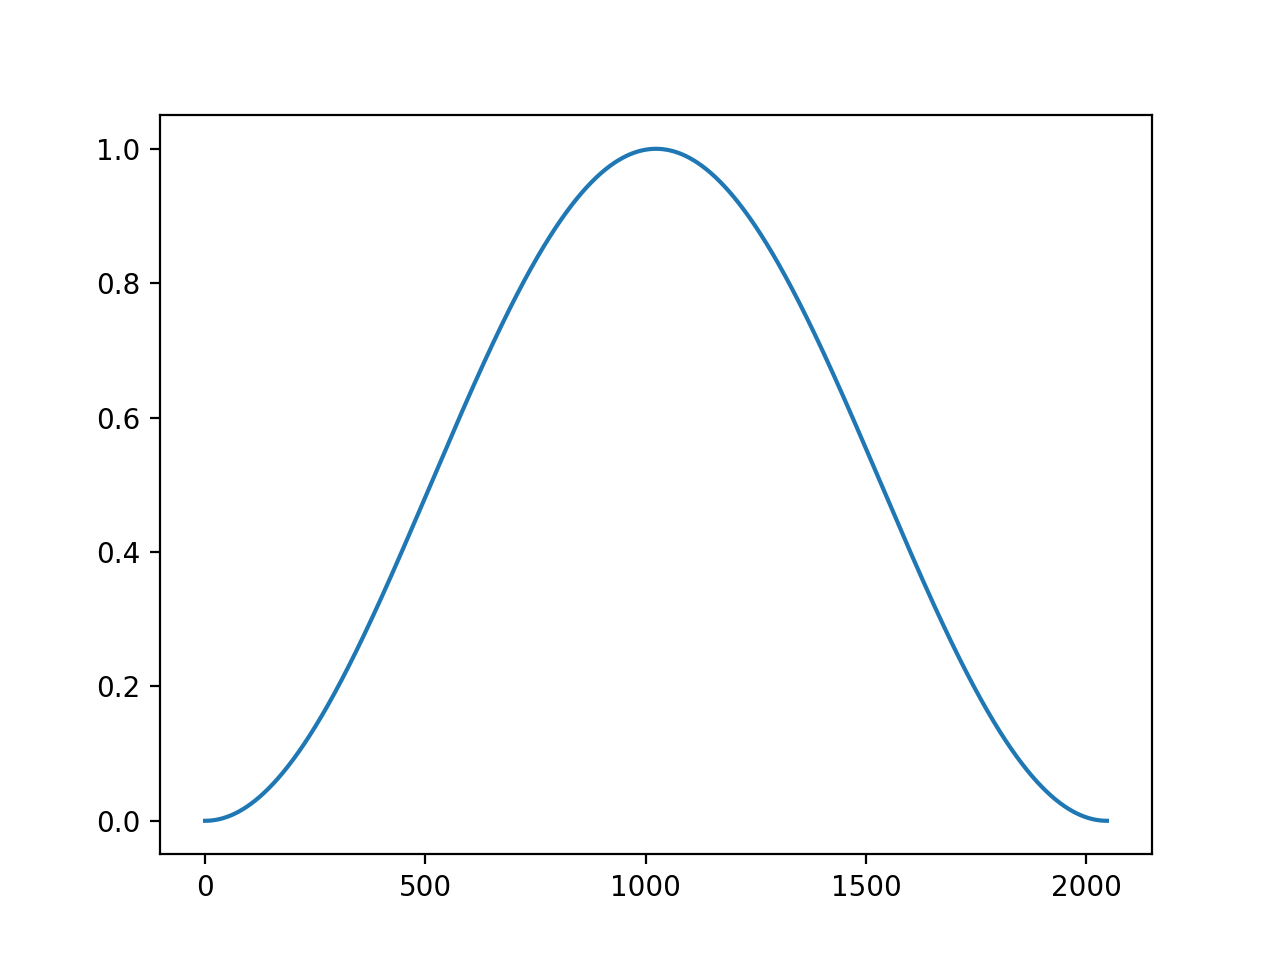

In [398]:
plt.figure()
plt.plot(t, window_data)
plt.show()

In [404]:
mse = np.sum((x-y_hat)**2)
mse

4.980039118145724e-21

<IPython.core.display.Javascript object>


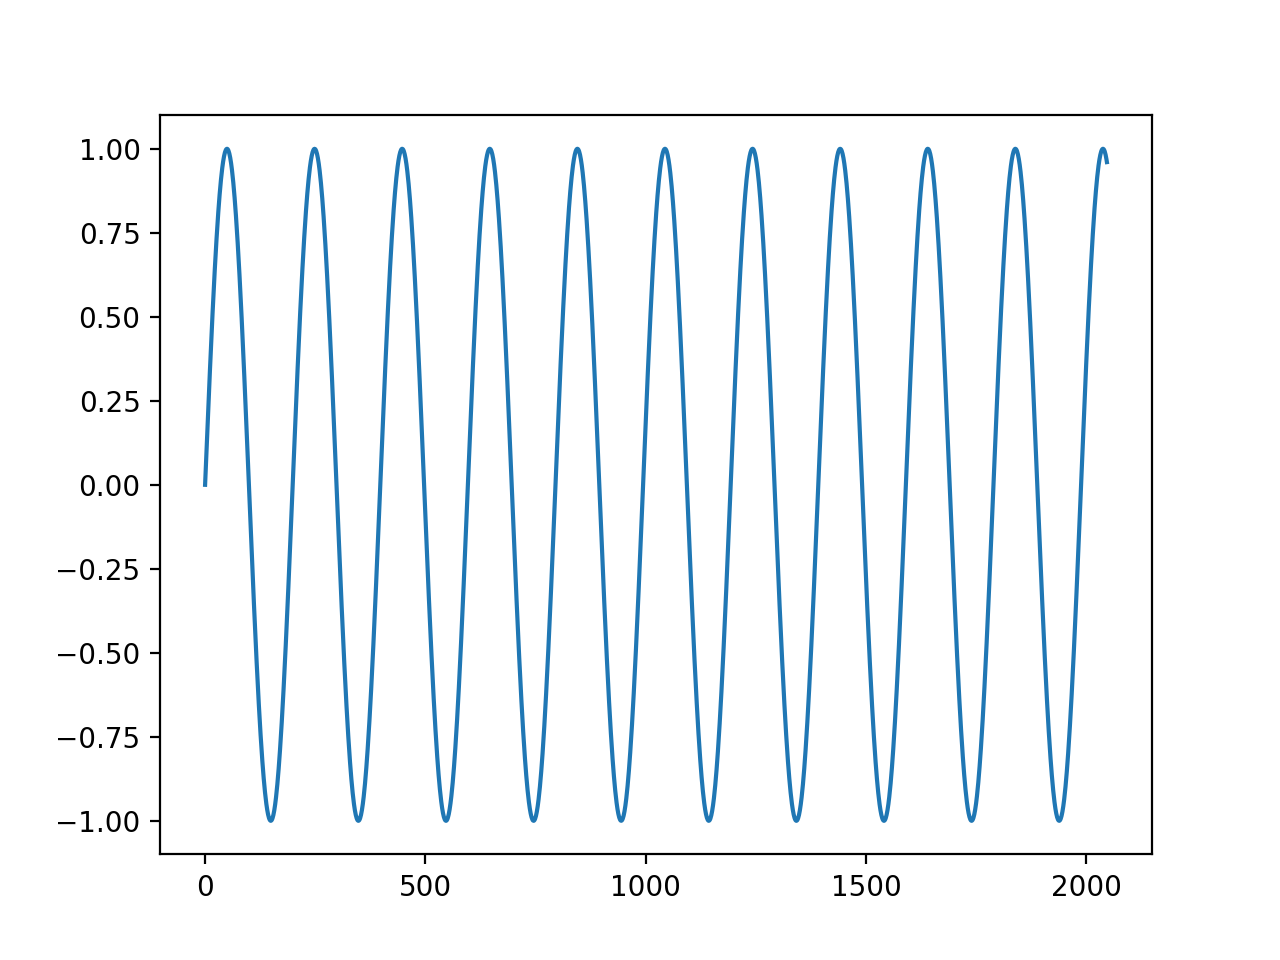

In [391]:
plt.figure()
plt.plot(t, y_hat)
plt.show()

In [313]:
w = np.arange(0,1025)

<IPython.core.display.Javascript object>


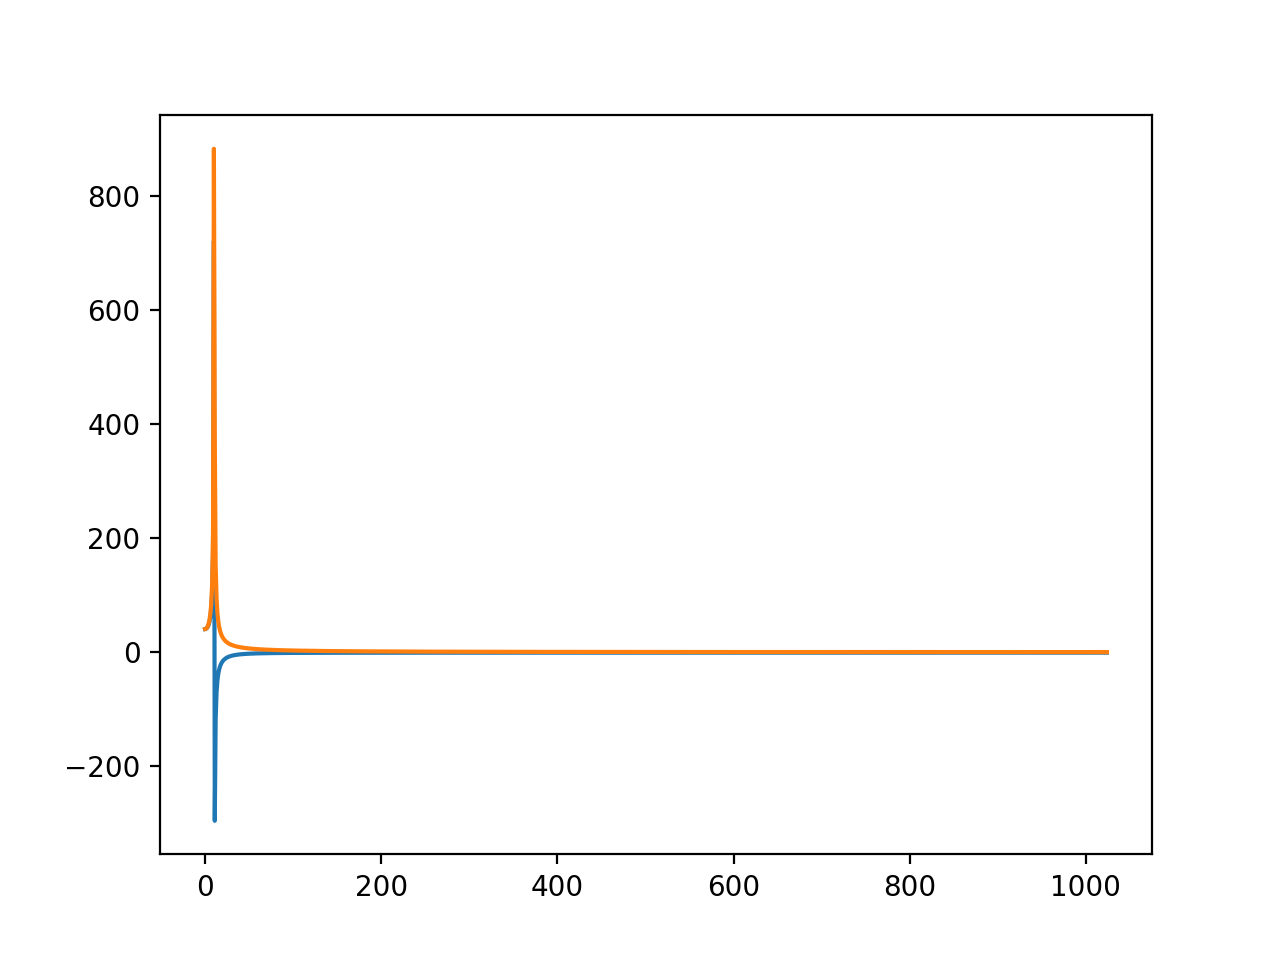

In [345]:
plt.figure()
plt.plot(w, np.real(X[:, 0]))
plt.plot(w, X_abs[:, 0])
plt.show()

<IPython.core.display.Javascript object>


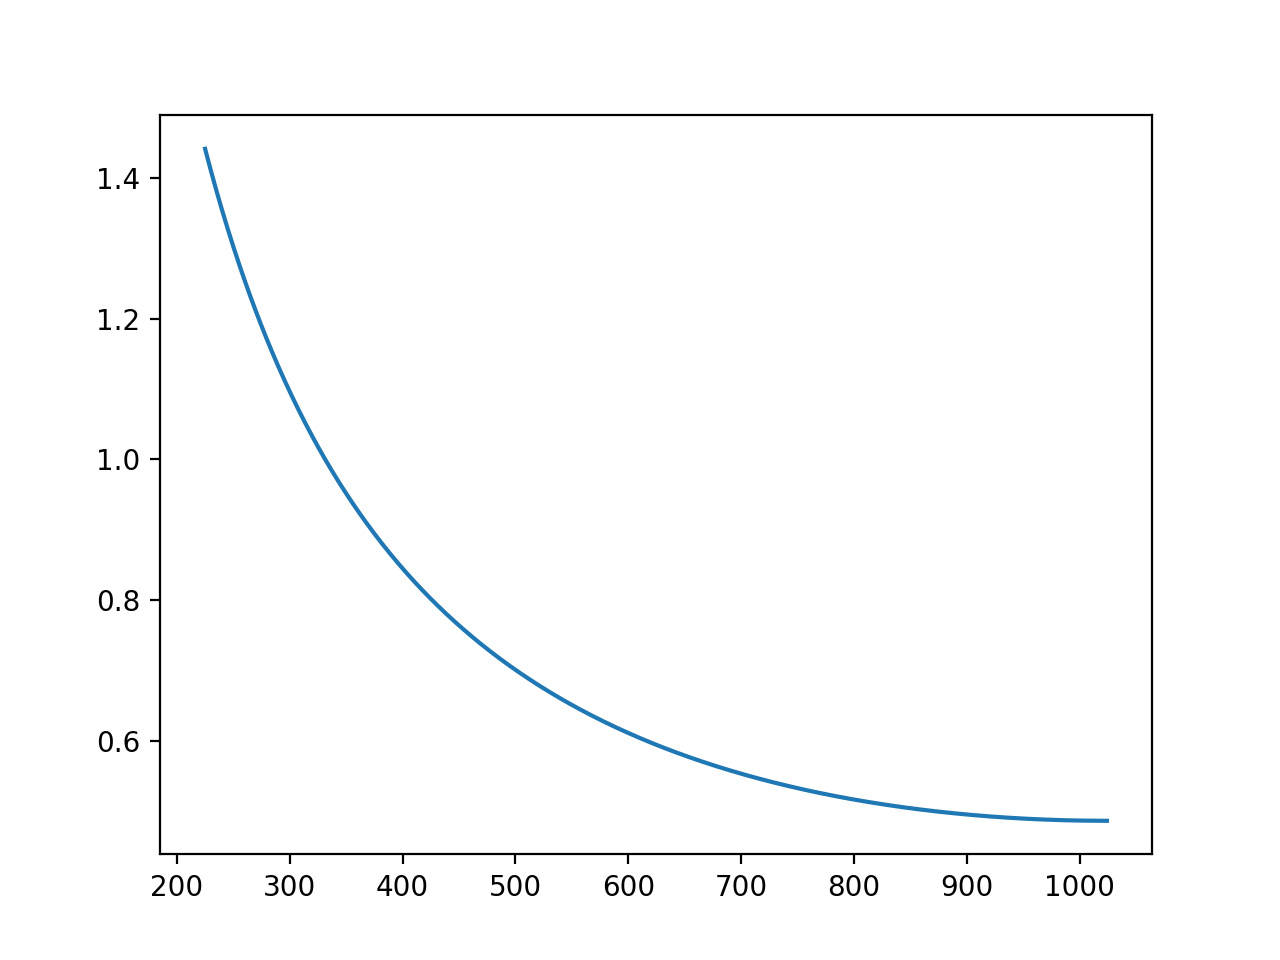

In [344]:
f_center = N
f_start = int(f_center) - 100
f_end = int(f_center) + 100
if f_start < 0:
    f_start = 0
sl = slice(f_start, f_end)
plt.figure()
#plt.plot(w[0:100], X[:, 0][0:100])
#plt.plot(w[sl], X_abs[:, 0][sl])
plt.plot(w[-800:], X_abs[:, 0][-800:])
plt.show()

<IPython.core.display.Javascript object>


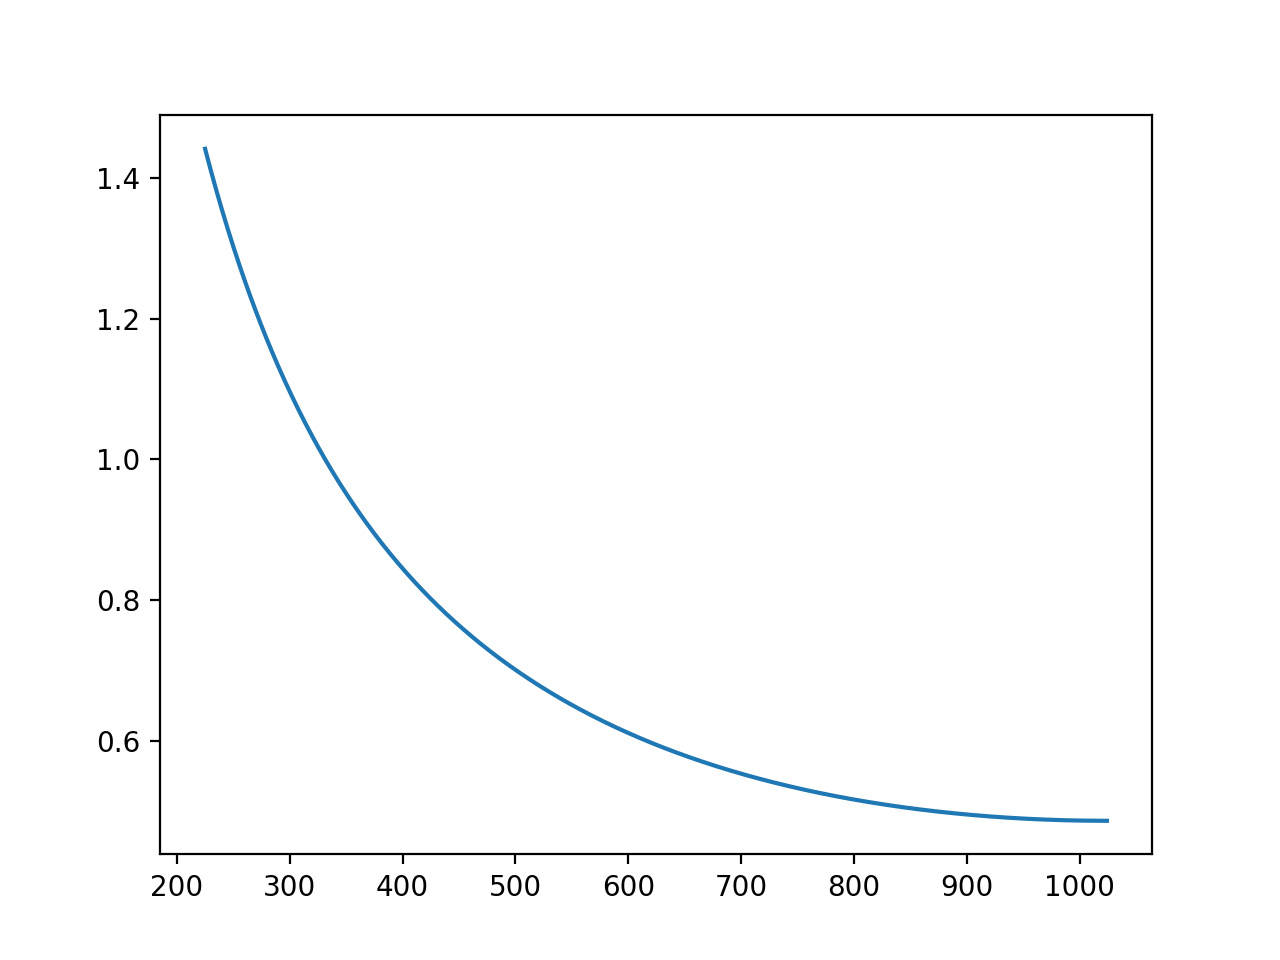

In [361]:
f_center = N
f_start = int(f_center) - 100
f_end = int(f_center) + 100
if f_start < 0:
    f_start = 0
sl = slice(f_start, f_end)
plt.figure()
#plt.plot(w[0:100], X[:, 0][0:100])
#plt.plot(w[sl], X_abs[:, 0][sl])
plt.plot(w[-800:], X_abs[:, 0][-800:])
plt.show()

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
rng = np.random.default_rng()

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power),
                   size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

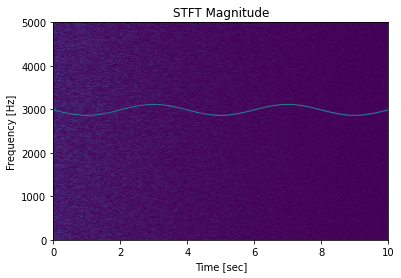

In [3]:
f, t, Zxx = signal.stft(x, fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [5]:
f.shape

(501,)

# n_fft

The default value, n_fft=2048 samples, corresponds to a physical duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the default sample rate in librosa. This value is well adapted for music signals. However, in speech processing, the recommended value is 512, corresponding to 23 milliseconds at a sample rate of 22050 Hz. In any case, we recommend setting n_fft to a power of two for optimizing the speed of the fast Fourier transform (FFT) algorithm.  

http://librosa.org/doc/main/generated/librosa.stft.html  

In [3]:
n_fft = 2048
sr = 22050
print('duration = %g msec'%(float(n_fft)/sr*1000))

92.8798 msec


In [4]:
n_fft = 320
sr = 16000
print('duration = %g msec'%(float(n_fft)/sr*1000))

duration = 20 msec


**TSCN parmeters**  
All the utterances are sampled at 16kHz. The 20ms Hanning window is adopted with 50% overlap between consecutive frames. To extract the spectral features, 320-point FFT is utilized.

# convolution

$$
q(x) = (f*g)(x)\equiv{1\over\sqrt{2\pi}}\int_{-\infty}^\infty g(y)f(x-y)dy
$$

$$
Q(t) = {1\over\sqrt{2\pi}}\int_{-\infty}^\infty dx
\left[ {1\over\sqrt{2\pi}}\int dy\ g(y)f(x-y)\right]e^{itx} \\
= \left[ {1\over\sqrt{2\pi}}\int dy\ g(y)e^{ity} \right]
\left[{1\over\sqrt{2\pi}}\int dx f(x-y)e^{it(x-y)} \right] \\
= G(t)F(t)
$$

**Impulse response**  
$$
q(t) = h(f(t)) \\
h(af(t)+bg(t)) = ah(f(t))+bh(g(t))
$$

$$
\begin{align*}
q(t) &= h(f(t))\\
&= h\left(\int f(u)\delta(u-t) du\right)\\
&= \int f(u)\underbrace{h(\delta(u-t))}_{\equiv g(t-u)} du\\
&= \sqrt{2\pi} (f*g)(t)
\end{align*}\\
$$